In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import re
import glob
import suftware as su
from scipy.stats import norm
from scipy.stats import poisson

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

e = np.exp(1)
pi = np.pi
def pseudo_log(x,base=e):
    return np.log(x+.5)/np.log(base)

['../../../../mavenn']


In [2]:
# Get in-file
data_dir = '/Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/'
in_file = data_dir + 'results.brca2_9nt_lib1_rep1.txt'
        
# Create dict to record statistics
stats_dict = {}
        
# Load file
in_df = pd.read_csv(in_file, delimiter='\t', index_col=0)
print(f'Processing {in_file}')

# Remove extraneous columns
del in_df['mis_ct']
del in_df['lib_ct']

in_df.head()

Processing /Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/results.brca2_9nt_lib1_rep1.txt


,tot_ct,ex_ct,ss,bc
0,377,27,ACAGCGGGA,TTAGCTATCGGCTGACGTCT
1,332,5,AGCGTGTAT,CCACCCAACGCGCCGTCAGT
2,320,3286,CAGGTGAGA,TTGAGGTACACTGAACAGTC
3,312,2248,CAGGTTAGA,ACCGATCTGCCACGGCGACC
4,291,8,CAAGCCTTA,AGGGACCATCCAGTTCGCCT


In [3]:
# Marginalize by splice site
data_df = in_df.groupby('ss').sum()
data_df.reset_index(inplace=True)

<AxesSubplot:xlabel='tot_ct', ylabel='Count'>

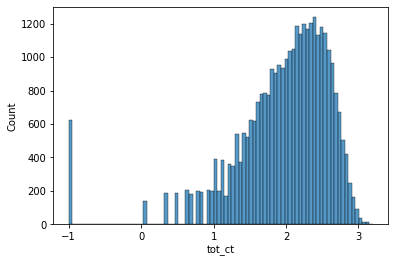

In [4]:
# Look at tot_ct distribution
sns.histplot(np.log10(data_df['tot_ct']+.1))

In [5]:
# Rename columns
data_df.rename(columns={'ss':'x'}, inplace=True)

# Make sequences RNA
data_df['x'] = [ss.replace('T','U') for ss in data_df['x']]

# Remove ss with minimum tot_ct
min_ct = 10
ix = data_df['tot_ct'] >= min_ct
data_df = data_df[ix]
print(f'{(~ix).sum()} ss removed for having tot_ct < {min_ct}')

# Remove ss with invalid sequences
ix = np.array([((x[3]=='G') and (x[4] in {'C','U'})) for x in data_df['x']])
data_df = data_df[ix]
print(f'{(~ix).sum()} ss with invalid sequences removed')

# Compute y
i_n = data_df['tot_ct']
o_n = data_df['ex_ct']
y_n = np.log2((o_n+1)/(i_n+1))
data_df['y'] = y_n

# Assign to trianing and test sets
N = len(data_df)
training_frac=.8
np.random.seed(0)
r = np.random.rand(N)
test_frac = .2
val_frac = .2
ix_train = (test_frac + val_frac <= r)
ix_val = (test_frac <= r) & (r < test_frac + val_frac)
ix_test = (r < test_frac)
data_df['set'] = ''
data_df.loc[ix_train, 'set'] = 'training'
data_df.loc[ix_val, 'set'] = 'validation'
data_df.loc[ix_test, 'set'] = 'test'
assert all([len(x)>0 for x in data_df['set']])

# Shuffle data for extra safety
data_df = data_df.sample(frac=1).reset_index(drop=True)

# Order columns
data_df = data_df[['set', 'tot_ct', 'ex_ct', 'y', 'x']]

# Preview dataframe
print(f'N: {N:,}')
data_df.head(20)

2309 ss removed for having tot_ct < 10
7 ss with invalid sequences removed
N: 30,483


,set,tot_ct,ex_ct,y,x
0,training,28,2,-3.273018,GGAGUGAUG
1,training,315,7,-5.303781,AGUGUGCAA
2,test,193,15,-3.599913,UUCGCGCCA
3,validation,27,0,-4.807355,UAAGCUUUU
4,training,130,2,-5.448461,AUGGUCGGG
5,training,552,19,-4.789208,AGGGCAGGA
6,training,151,184,0.283454,AAGGUCCGC
7,test,216,6,-4.954196,GGUGUCUGU
8,training,88,4,-4.153805,CAGGCAAAC
9,training,105,5,-4.142958,GUGGCAAAU


In [6]:
# Show size of compressed dataset file
file_name = 'mpsa_data.csv.gz'
data_df.to_csv(file_name, compression='gzip', index=False)
print('df (zipped):')
!du -mh $file_name
!mv $file_name ../.

df (zipped):
388K	mpsa_data.csv.gz


In [7]:
# Test loading
loaded_df = mavenn.load_example_dataset('mpsa')
loaded_df.head()

,set,tot_ct,ex_ct,y,x
0,training,28,2,-3.273018,GGAGUGAUG
1,training,315,7,-5.303781,AGUGUGCAA
2,test,193,15,-3.599913,UUCGCGCCA
3,validation,27,0,-4.807355,UAAGCUUUU
4,training,130,2,-5.448461,AUGGUCGGG
